### Low-dimensional embedding of the left and right hemisphere - a novel framework for asymmetry research

Structural brain asymmetries are typically investigating using various parcellation schemes.
However, differences in the global architecture of the two hemispheres have not been investigated using embedding approaches.



In [1]:
import umap
import glob
import nilearn as nl
from nilearn import image
import numpy as np
import pandas as pd
from inspect import getmembers, isfunction

import seaborn as sns
import hdbscan        # clustering

import hdbscan

from matplotlib import pyplot as plt

<ipython-input-85-3d9f437e8564>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  nl_img = nl_img.get_data()


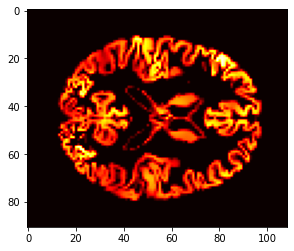

In [85]:
##### directories
datapaths = glob.glob('./data/*sub-*GMvolume.nii.gz')

### vessel
nl_img = nl.image.threshold_img(datapaths[0], 0.1) 
nl_img = nl_img.get_data()

all_img = np.zeros([len(datapaths), nl_img.shape[0],  nl_img.shape[1],  nl_img.shape[2]])
#example_img.shape # this gives (91, 109, 91)

plt.imshow(nl_img[:,:,45], cmap='hot')
plt.show()

In [86]:
### read in all images
datapaths = sorted(datapaths)

for subj in range(len(datapaths)):
    t12use = nl.image.threshold_img(datapaths[subj], 0.1) 
    t12use = t12use.get_fdata()
    all_img[subj,:,:,:] = t12use

#all_img.shape

<ipython-input-86-22369633d41d>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  t12use = t12use.get_data()


(442, 91, 109, 91)

In [87]:
### split left and right hemisphere and flip the left onto the right
all_rh = all_img[:, :45, :, :]; print(all_rh.shape)
all_lh = all_img[:, 46:, :, :]; print(all_lh.shape)
all_lh_flipped = np.flip(all_lh, 1); print(all_lh_flipped.shape)


(442, 45, 109, 91)
(442, 45, 109, 91)
(442, 45, 109, 91)


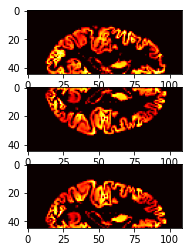

In [88]:
### visualize first vp
z = 45 # z coordinate
fig = plt.figure()
# right
ax1 = fig.add_subplot(3,1,1)
ax1.imshow(all_rh[0, :, :, z], cmap='hot')
# left flipped
ax2 = fig.add_subplot(3,1,2)
ax2.imshow(all_lh[0, :, :, z], cmap='hot')
# left flipped
ax3 = fig.add_subplot(3,1,3)
ax3.imshow(all_lh_flipped[0, :, :, z], cmap='hot')

# show
plt.show()

In [97]:
### reshape

# right hemispheres
all_rh_2d = np.reshape(all_rh, (all_rh.shape[0], all_rh.shape[1]*all_rh.shape[2]*all_rh.shape[3]))
print(all_rh_2d.shape)

# left_flipped hemispheres
all_lh_flipped_2d = np.reshape(all_lh_flipped, (all_lh_flipped.shape[0], all_lh_flipped.shape[1]*all_lh_flipped.shape[2]*all_lh_flipped.shape[3]))
print(all_lh_flipped_2d.shape)

# concatenate the two matrices
X_bothDatasets = np.concatenate((all_rh_2d, all_lh_flipped_2d), axis=0)
print('concat:' + str(X.shape))


### both data separately
# rh
piop1_rh_2d = all_rh_2d[:216, :]; print('piop1_rh_2d'+str(piop1_rh_2d.shape))
piop2_rh_2d = all_rh_2d[216:, :]; print('piop2_rh_2d'+str(piop2_rh_2d.shape))
# lh
piop1_lh_2d = all_lh_flipped_2d[:216, :]; print('piop1_lh_2d'+str(piop1_lh_2d.shape))
piop2_lh_2d = all_lh_flipped_2d[216:, :]; print('piop2_lh_2d'+str(piop2_lh_2d.shape))
# concat
piop1_X = np.concatenate((piop1_rh_2d, piop1_lh_2d), axis = 0); print('piop1 concat'+str(piop1_X.shape))
piop2_X = np.concatenate((piop2_rh_2d, piop2_lh_2d), axis = 0); print('piop2 concat'+str(piop2_X.shape))


(442, 446355)
(442, 446355)
concat:(884, 446355)
piop1_rh_2d(216, 446355)
piop2_rh_2d(226, 446355)
piop1_lh_2d(216, 446355)
piop2_lh_2d(226, 446355)
piop1 concat(432, 446355)
piop2 concat(452, 446355)


<function matplotlib.pyplot.show(*args, **kw)>

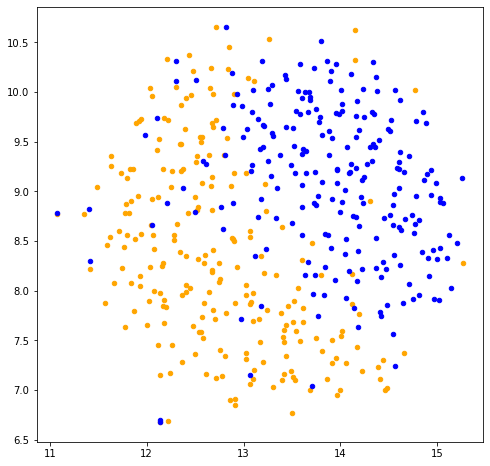

In [99]:
### UMAP :)
#embX = umap.UMAP(random_state=25,n_neighbors=50, min_dist=0.0, n_components=2).fit_transform(X)
emb = umap.UMAP(random_state=25,n_neighbors=30, min_dist=0.0, n_components=2).fit_transform(piop2_X)

### visualize embedding
fig = plt.figure(figsize=(8,8))
plt.scatter(emb[:226,0], emb[:226,1], s=20, c='Orange')
plt.scatter(emb[226:,0], emb[226:,1], s=20, c='Blue')
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

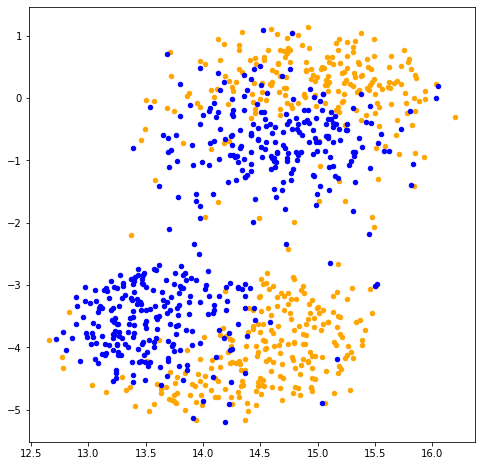

In [92]:
'''### visualize embedding
fig = plt.figure(figsize=(8,8))
plt.scatter(emb[:442,0], emb[:442,1], s=20, c='Orange')
plt.scatter(emb[442:,0], emb[442:,1], s=20, c='Blue')
plt.show'''

In [63]:
### demographics
df = pd.read_csv('participants_piop2.tsv', delimiter="\t")

### insert umap dimensions
df['rh_dim1']=emb[:226, 0]
df['rh_dim2']=emb[:226, 1]
df['lh_dim1']=emb[226:, 0]
df['lh_dim2']=emb[226:, 1]
df.head()

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C,rh_dim1,rh_dim2,lh_dim1,lh_dim2
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32,11.926077,8.050285,13.581585,10.281377
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46,12.243336,7.175428,15.260092,9.135234
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48,11.618367,8.538898,14.649511,7.875712
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52,11.591818,8.456525,14.331758,9.796007
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53,11.892230,9.684585,11.984334,9.565227


<function matplotlib.pyplot.show(*args, **kw)>

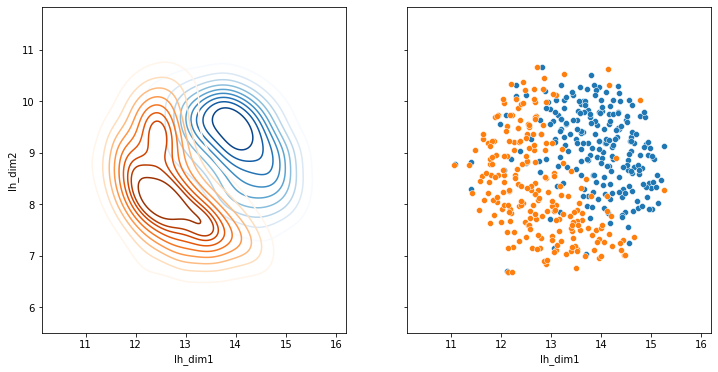

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
sns.kdeplot(x=df.lh_dim1, y=df.lh_dim2, ax=ax[0], cmap='Blues', shade=False, thresh=0.1)
sns.kdeplot(x=df.rh_dim1, y=df.rh_dim2, ax=ax[0], cmap='Oranges', shade=False, thresh=0.1)
sns.scatterplot(x='lh_dim1', y='lh_dim2', data=df, ax=ax[1], cmap="Blues")
sns.scatterplot(x='rh_dim1', y='rh_dim2', data=df, ax=ax[1], cmap="Oranges")
plt.show

In [ ]:
### WIP --> create a new DF with [(226*2), Demographic information]
# sns.jointplot(data=df x)

/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(*args, **kw)>

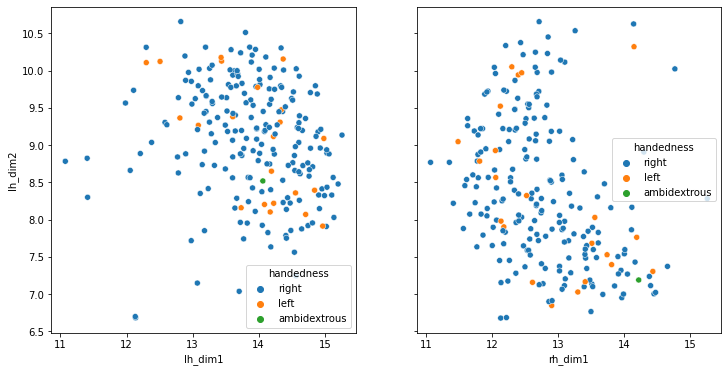

In [46]:
### systematic relation with handedness?

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.scatterplot('lh_dim1', 'lh_dim2', hue='handedness', data=df, ax=ax[0])
sns.scatterplot('rh_dim1', 'rh_dim2', hue='handedness', data=df, ax=ax[1])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

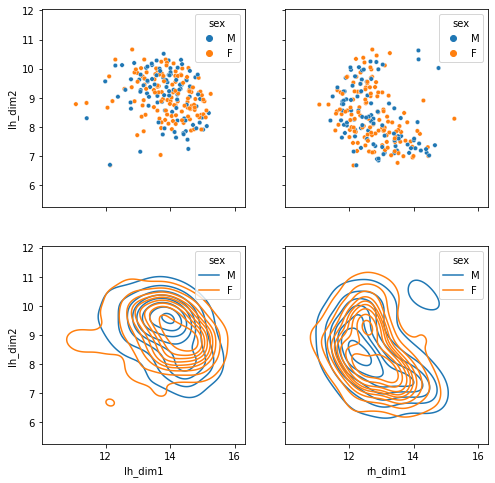

In [30]:
### view at the distribution of males and females

fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True)
#fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='lh_dim1', y='lh_dim2', data=df, hue='sex', ax=ax[0,0], s=20)
sns.scatterplot(x='rh_dim1', y='rh_dim2', data=df, hue='sex', ax=ax[0,1], s=20)
sns.kdeplot(x='lh_dim1', y='lh_dim2', data=df, hue='sex', ax=ax[1,0])
sns.kdeplot(x='rh_dim1', y='rh_dim2', data=df, hue='sex', ax=ax[1,1])
plt.show

/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(*args, **kw)>

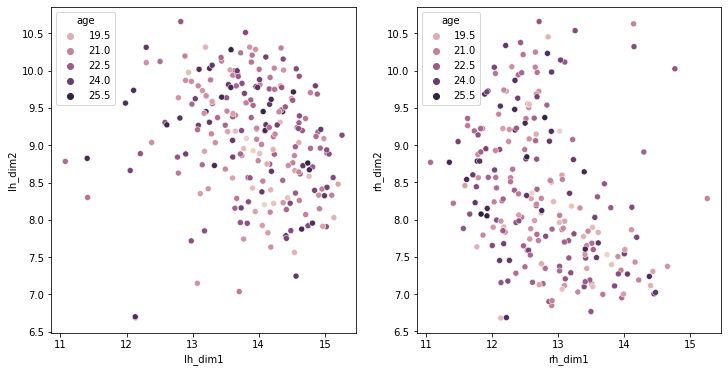

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
sns.scatterplot('lh_dim1', 'lh_dim2', hue='age', data=demographics, ax=ax[0], cmap='blues')
sns.scatterplot('rh_dim1', 'rh_dim2', hue='age', data=demographics, ax=ax[1], cmap='blues')
plt.show

/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pat/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

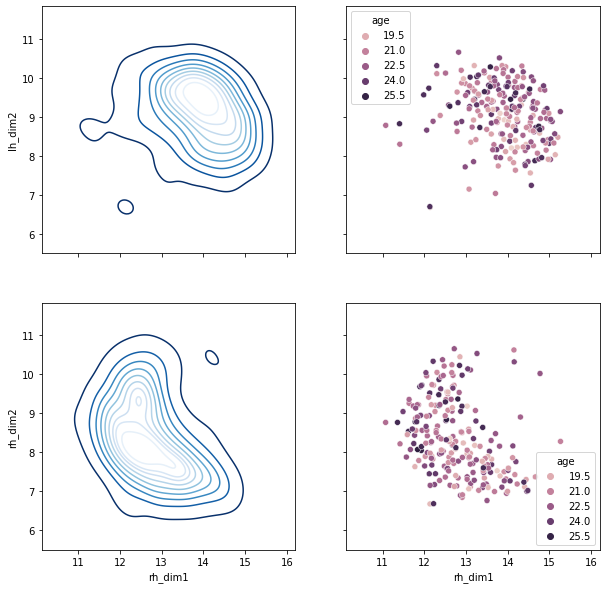

In [45]:

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
sns.kdeplot(df.lh_dim1, df.lh_dim2, ax=ax[0,0], cmap='Blues_r')
sns.scatterplot('lh_dim1', 'lh_dim2', hue='age', data=df, ax=ax[0,1], cmap='blues')
sns.kdeplot(df.rh_dim1, df.rh_dim2, ax=ax[1,0], cmap='Blues_r')
sns.scatterplot('rh_dim1', 'rh_dim2', hue='age', data=df, ax=ax[1,1], cmap='blues')




In [191]:
### Trying to visualize the pairs (hemispheres from the same participant)
# not working yet -.-
'''fig = plt.figure(figsize=(6,6))
#plt.scatter(df['lh_dim1'], df['lh_dim2'], cmap="Blues", s=30)
#plt.scatter(df['rh_dim1'], df['rh_dim2'], cmap="Oranges", s=30)
sns.kdeplot(df.lh_dim1, df.lh_dim2, cmap='Blues', shade=False, shade_lowest=False)
sns.kdeplot(df.rh_dim1, df.rh_dim2, cmap='Oranges', shade=False, shade_lowest=False)

for i in range(0, 226):
    plt.plot([df['lh_dim1'][i], df['lh_dim2'][i]], [df['rh_dim1'][i], df['rh_dim2'][i]], c='k', linewidth=0.5)

plt.show
'''

'fig = plt.figure(figsize=(6,6))\n#plt.scatter(df[\'lh_dim1\'], df[\'lh_dim2\'], cmap="Blues", s=30)\n#plt.scatter(df[\'rh_dim1\'], df[\'rh_dim2\'], cmap="Oranges", s=30)\nsns.kdeplot(df.lh_dim1, df.lh_dim2, cmap=\'Blues\', shade=False, shade_lowest=False)\nsns.kdeplot(df.rh_dim1, df.rh_dim2, cmap=\'Oranges\', shade=False, shade_lowest=False)\n\nfor i in range(0, 226):\n    plt.plot([df[\'lh_dim1\'][i], df[\'lh_dim2\'][i]], [df[\'rh_dim1\'][i], df[\'rh_dim2\'][i]], c=\'k\', linewidth=0.5)\n\nplt.show\n'

### clustering / classifier

In [72]:
### try hdbscan with higher components
embC = umap.UMAP(random_state=30, n_neighbors=30, min_dist=0.0, n_components=226).fit_transform(piop2_X)
#label = hdbscan.HDBSCAN().fit_predict(embC)


In [75]:
'''### visualize embedding
fig = plt.figure(figsize=(12,12))
#ax = fig.add_subplot(111, projection='polar')
ax = fig.add_subplot(111)
clustered = (label >= 0)
ax.scatter(embC[~clustered, 0],
            embC[~clustered, 1],
            facecolors='none',
            edgecolors='black',
            s=15)
ax.scatter(embC[clustered, 0],
            embC[clustered, 1],
            c=label[clustered],
            s=15,
            cmap='Paired');
plt.show
#plt.savefig('figure_UMAP_HDBSCAN.png')'''

"### visualize embedding\nfig = plt.figure(figsize=(12,12))\n#ax = fig.add_subplot(111, projection='polar')\nax = fig.add_subplot(111)\nclustered = (label >= 0)\nax.scatter(embC[~clustered, 0],\n            embC[~clustered, 1],\n            facecolors='none',\n            edgecolors='black',\n            s=15)\nax.scatter(embC[clustered, 0],\n            embC[clustered, 1],\n            c=label[clustered],\n            s=15,\n            cmap='Paired');\nplt.show\n#plt.savefig('figure_UMAP_HDBSCAN.png')"

<function matplotlib.pyplot.show(*args, **kw)>

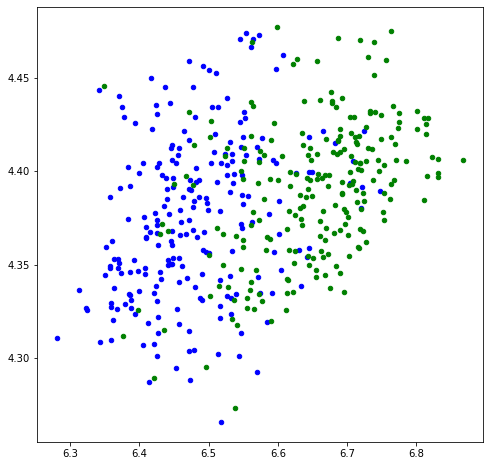

In [82]:
fig = plt.figure(figsize=(8,8))
plt.scatter(embC[:226,0], embC[:226,1], s=20, c='Blue')
plt.scatter(embC[226:,0], embC[226:,1], s=20, c='Green')
plt.show


In [102]:
embC.shape # indicating that there are 452 hemispheres and 226 components

(452, 226)

In [176]:
dim = ['dim0', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16', 'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24', 'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32', 'dim33', 'dim34', 'dim35', 'dim36', 'dim37', 'dim38', 'dim39', 'dim40', 'dim41', 'dim42', 'dim43', 'dim44', 'dim45', 'dim46', 'dim47', 'dim48', 'dim49', 'dim50', 'dim51', 'dim52', 'dim53', 'dim54', 'dim55', 'dim56', 'dim57', 'dim58', 'dim59', 'dim60', 'dim61', 'dim62', 'dim63', 'dim64', 'dim65', 'dim66', 'dim67', 'dim68', 'dim69', 'dim70', 'dim71', 'dim72', 'dim73', 'dim74', 'dim75', 'dim76', 'dim77', 'dim78', 'dim79', 'dim80', 'dim81', 'dim82', 'dim83', 'dim84', 'dim85', 'dim86', 'dim87', 'dim88', 'dim89', 'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98', 'dim99', 'dim100', 'dim101', 'dim102', 'dim103', 'dim104', 'dim105', 'dim106', 'dim107', 'dim108', 'dim109', 'dim110', 'dim111', 'dim112', 'dim113', 'dim114', 'dim115', 'dim116', 'dim117', 'dim118', 'dim119', 'dim120', 'dim121', 'dim122', 'dim123', 'dim124', 'dim125', 'dim126', 'dim127', 'dim128', 'dim129', 'dim130', 'dim131', 'dim132', 'dim133', 'dim134', 'dim135', 'dim136', 'dim137', 'dim138', 'dim139', 'dim140', 'dim141', 'dim142', 'dim143', 'dim144', 'dim145', 'dim146', 'dim147', 'dim148', 'dim149', 'dim150', 'dim151', 'dim152', 'dim153', 'dim154', 'dim155', 'dim156', 'dim157', 'dim158', 'dim159', 'dim160', 'dim161', 'dim162', 'dim163', 'dim164', 'dim165', 'dim166', 'dim167', 'dim168', 'dim169', 'dim170', 'dim171', 'dim172', 'dim173', 'dim174', 'dim175', 'dim176', 'dim177', 'dim178', 'dim179', 'dim180', 'dim181', 'dim182', 'dim183', 'dim184', 'dim185', 'dim186', 'dim187', 'dim188', 'dim189', 'dim190', 'dim191', 'dim192', 'dim193', 'dim194', 'dim195', 'dim196', 'dim197', 'dim198', 'dim199', 'dim200', 'dim201', 'dim202', 'dim203', 'dim204', 'dim205', 'dim206', 'dim207', 'dim208', 'dim209', 'dim210', 'dim211', 'dim212', 'dim213', 'dim214', 'dim215', 'dim216', 'dim217', 'dim218', 'dim219', 'dim220', 'dim221', 'dim222', 'dim223', 'dim224', 'dim225']

dfC = pd.DataFrame(data=embC, columns=dim);
dfC.head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim216,dim217,dim218,dim219,dim220,dim221,dim222,dim223,dim224,dim225
0,6.280772,4.310748,6.602275,3.485162,5.049507,4.176927,5.519099,4.505813,7.616447,4.210297,...,6.436928,6.328852,5.151928,3.987913,4.305822,3.731900,5.135342,6.117001,5.109804,5.099270
1,6.445663,4.412360,6.480027,3.398430,5.031070,4.290050,5.467796,4.480085,7.521111,4.255491,...,6.495790,6.311104,5.224122,3.904793,4.314938,3.754571,5.163833,6.162672,5.045330,5.156019
2,6.324621,4.325474,6.583862,3.389342,5.051791,4.024093,5.400999,4.530959,7.530663,4.272104,...,6.447502,6.324560,5.217733,3.958182,4.316702,3.744176,5.136272,6.124152,5.098567,5.122722
3,6.322679,4.326981,6.540458,3.436965,5.064066,4.214604,5.492896,4.479092,7.569149,4.215601,...,6.451712,6.329874,5.194480,3.958632,4.306135,3.738254,5.136636,6.128901,5.083612,5.119166
4,6.426388,4.313107,6.573830,3.531829,5.028437,4.128971,5.412782,4.347447,7.650903,4.041227,...,6.436484,6.307912,5.123703,4.011415,4.281784,3.737006,5.106419,6.133748,5.130499,5.074357


In [182]:
#dim = ['dim0', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16', 'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24', 'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32', 'dim33', 'dim34', 'dim35', 'dim36', 'dim37', 'dim38', 'dim39', 'dim40', 'dim41', 'dim42', 'dim43', 'dim44', 'dim45', 'dim46', 'dim47', 'dim48', 'dim49', 'dim50', 'dim51', 'dim52', 'dim53', 'dim54', 'dim55', 'dim56', 'dim57', 'dim58', 'dim59', 'dim60', 'dim61', 'dim62', 'dim63', 'dim64', 'dim65', 'dim66', 'dim67', 'dim68', 'dim69', 'dim70', 'dim71', 'dim72', 'dim73', 'dim74', 'dim75', 'dim76', 'dim77', 'dim78', 'dim79', 'dim80', 'dim81', 'dim82', 'dim83', 'dim84', 'dim85', 'dim86', 'dim87', 'dim88', 'dim89', 'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98', 'dim99', 'dim100', 'dim101', 'dim102', 'dim103', 'dim104', 'dim105', 'dim106', 'dim107', 'dim108', 'dim109', 'dim110', 'dim111', 'dim112', 'dim113', 'dim114', 'dim115', 'dim116', 'dim117', 'dim118', 'dim119', 'dim120', 'dim121', 'dim122', 'dim123', 'dim124', 'dim125', 'dim126', 'dim127', 'dim128', 'dim129', 'dim130', 'dim131', 'dim132', 'dim133', 'dim134', 'dim135', 'dim136', 'dim137', 'dim138', 'dim139', 'dim140', 'dim141', 'dim142', 'dim143', 'dim144', 'dim145', 'dim146', 'dim147', 'dim148', 'dim149', 'dim150', 'dim151', 'dim152', 'dim153', 'dim154', 'dim155', 'dim156', 'dim157', 'dim158', 'dim159', 'dim160', 'dim161', 'dim162', 'dim163', 'dim164', 'dim165', 'dim166', 'dim167', 'dim168', 'dim169', 'dim170', 'dim171', 'dim172', 'dim173', 'dim174', 'dim175', 'dim176', 'dim177', 'dim178', 'dim179', 'dim180', 'dim181', 'dim182', 'dim183', 'dim184', 'dim185', 'dim186', 'dim187', 'dim188', 'dim189', 'dim190', 'dim191', 'dim192', 'dim193', 'dim194', 'dim195', 'dim196', 'dim197', 'dim198', 'dim199', 'dim200', 'dim201', 'dim202', 'dim203', 'dim204', 'dim205', 'dim206', 'dim207', 'dim208', 'dim209', 'dim210', 'dim211', 'dim212', 'dim213', 'dim214', 'dim215', 'dim216', 'dim217', 'dim218', 'dim219', 'dim220', 'dim221', 'dim222', 'dim223', 'dim224', 'dim225']
dim = ['dim'+str(x) for x in range(len(embC[0]))]
dfC = pd.DataFrame(data=embC, columns=dim);
#dfC.head()

l = ['left']*226
r = ['right']*226
side = r+l
dfC.insert(0, 'side', side, True)
#dfC.head()
X=list(dfC.columns.map(str))
y=str(X[0])
X.pop(0)
#print(y)



side


In [124]:
from julearn import run_cross_validation
from julearn.utils import configure_logging

In [195]:
### accuracy
scores = run_cross_validation(X=X, y='side', data=dfC, model='svm', seed=42,
                              preprocess_X='zscore', scoring=['accuracy', 'balanced_accuracy'])

#print(scores['test_score'].mean())
print(scores['test_accuracy'].mean())
print(scores['test_balanced_accuracy'].mean())


0.8310378510378511
0.8315947401226463


In [196]:
### left hemisphere precision
precision_scores = run_cross_validation(X=X, y='side', data=dfC, model='svm', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='left')

print(precision_scores['test_precision'].mean())


0.8759275328316576


In [197]:
### right hemisphere precision
precision_scores_RH = run_cross_validation(X=X, y='side', data=dfC, model='svm', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='right')

print(precision_scores_RH['test_precision'].mean())

0.7964174563688757


-----
### sex classification by vbm-asymmetry
---

In [199]:
embC.shape

(452, 226)

In [202]:
piop1_asym = piop1_rh_2d - piop1_lh_2d
piop2_asym = piop2_rh_2d - piop2_lh_2d

piop2_asym.shape


(226, 446355)

In [214]:
### data
test = piop2_asym[0].reshape(45, 109, 91)
test_lh = piop2_rh_2d[0].reshape(45, 109, 91)

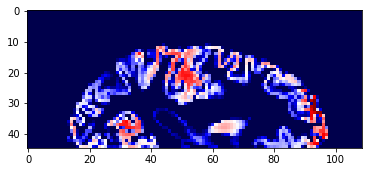

In [239]:
#plt.imshow(test[:,:,45])
plt.imshow(test_lh[:,:,45], cmap='seismic')

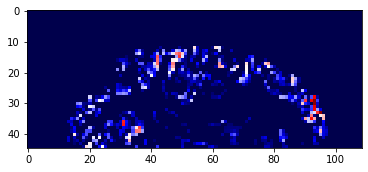

In [238]:
plt.imshow(test[:,:,45], cmap='seismic')

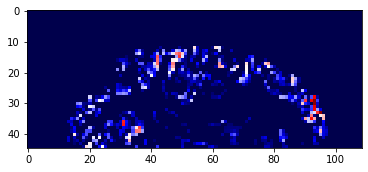

In [244]:
test = piop2_asym[0].reshape(45, 109, 91)
test[test[:,:,:]<0.01]=0
plt.imshow(test[:,:,45], cmap='seismic')
#arr[:, :, 1][arr[:, :, 1] < 10] = 0

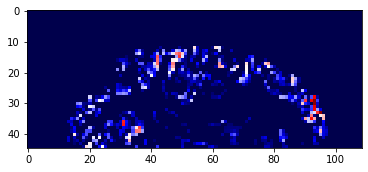

In [237]:
plt.imshow(test[:,:,45], cmap='seismic')

In [250]:
piop2_asym_thr = piop2_asym
piop2_asym_thr[piop2_asym_thr[:,:]<0.1]=0

In [252]:
piop2_asym.shape
piop2_X.shape

(452, 446355)

<function matplotlib.pyplot.show(*args, **kw)>

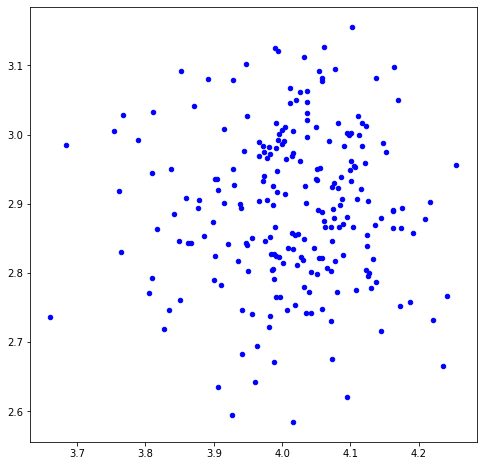

In [254]:
embC_asym_piop2 = umap.UMAP(random_state=30, n_neighbors=30,
                            min_dist=0.0, n_components=50).fit_transform(piop2_asym_thr)

fig = plt.figure(figsize=(8,8))
plt.scatter(embC_asym_piop2[:226,0], embC_asym_piop2[:226,1], s=20, c='Blue')
#plt.scatter(embC_asym_piop2[226:,0], embC_asym_piop2[226:,1], s=20, c='Green')
plt.show


In [266]:
dimColList = ['dim'+str(x) for x in range(len(embC_asym_piop2[0]))]; #print(dimColList)
temp = pd.DataFrame(data=embC_asym_piop2, columns=dimColList)
temp.head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim40,dim41,dim42,dim43,dim44,dim45,dim46,dim47,dim48,dim49
0,4.061409,3.126653,3.070598,4.023755,6.626189,6.246927,5.082429,4.849920,5.722446,3.751885,...,4.758849,7.932786,5.465585,5.479235,6.639692,3.996790,4.991270,4.615734,5.818538,4.628256
1,4.100967,2.933233,3.111568,3.830333,7.116581,6.093638,5.107379,5.072206,5.650229,3.812642,...,4.426185,7.677130,5.424805,5.343646,6.497702,4.211298,4.997031,4.644805,5.653584,4.456833
2,3.878801,2.905626,3.118993,3.543565,7.266408,6.104048,5.174057,5.203572,5.648838,3.750498,...,4.613971,7.932136,5.433778,5.485329,6.512827,4.002592,4.951531,4.619277,5.869025,4.737030
3,3.926558,2.594357,3.219247,3.770549,6.762057,6.028996,5.399756,5.146224,5.662997,3.885321,...,4.491725,7.743936,5.646932,5.174246,6.297762,4.004940,4.946239,4.132009,5.735505,4.491487
4,3.870430,3.041984,3.113682,3.801952,6.459620,6.386951,5.247724,4.690336,5.518440,3.776536,...,4.552210,7.825964,5.470165,5.378015,6.827349,4.147294,5.033405,4.238863,5.793243,4.834526


In [269]:
df_piop2 = df
df_piop2_asym = pd.concat([df, temp], axis=1)
df_piop2_asym.head()

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,...,dim40,dim41,dim42,dim43,dim44,dim45,dim46,dim47,dim48,dim49
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,...,4.758849,7.932786,5.465585,5.479235,6.639692,3.996790,4.991270,4.615734,5.818538,4.628256
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,...,4.426185,7.677130,5.424805,5.343646,6.497702,4.211298,4.997031,4.644805,5.653584,4.456833
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,...,4.613971,7.932136,5.433778,5.485329,6.512827,4.002592,4.951531,4.619277,5.869025,4.737030
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,...,4.491725,7.743936,5.646932,5.174246,6.297762,4.004940,4.946239,4.132009,5.735505,4.491487
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,...,4.552210,7.825964,5.470165,5.378015,6.827349,4.147294,5.033405,4.238863,5.793243,4.834526


In [283]:
### find the NaNs
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_piop2_asym[row_has_NaN]
print(rows_with_NaN)

### drop the NaN subjects

df_piop2_asym_corr = df_piop2_asym[df_piop2_asym.participant_id != 'sub-0105']
df_piop2_asym_corr = df_piop2_asym_corr[df_piop2_asym.participant_id != 'sub-0105']

df_piop2_asym_corr.participant_id.unique()

    participant_id  age  sex  BMI handedness education_category  raven_score  \
104       sub-0105  NaN  NaN  NaN        NaN                NaN          NaN   
198       sub-0199  NaN    F  NaN        NaN            applied         16.0   

     NEO_N  NEO_E  NEO_O  ...     dim40     dim41     dim42     dim43  \
104     13     43     35  ...  4.500684  7.284182  5.693126  5.006250   
198     41     52     41  ...  4.460975  7.757152  5.603515  5.179307   

        dim44     dim45     dim46     dim47     dim48     dim49  
104  6.329867  4.059394  4.999895  4.219678  5.662167  4.757451  
198  6.487298  4.014121  5.152749  4.353869  5.738574  4.468575  

[2 rows x 66 columns]


<ipython-input-283-e22555e80e5b>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_piop2_asym_corr = df_piop2_asym_corr[df_piop2_asym.participant_id != 'sub-0105']


array(['sub-0001', 'sub-0002', 'sub-0003', 'sub-0004', 'sub-0005',
       'sub-0006', 'sub-0007', 'sub-0008', 'sub-0009', 'sub-0010',
       'sub-0011', 'sub-0012', 'sub-0013', 'sub-0014', 'sub-0015',
       'sub-0016', 'sub-0017', 'sub-0018', 'sub-0019', 'sub-0020',
       'sub-0021', 'sub-0022', 'sub-0023', 'sub-0024', 'sub-0025',
       'sub-0026', 'sub-0027', 'sub-0028', 'sub-0029', 'sub-0030',
       'sub-0031', 'sub-0032', 'sub-0033', 'sub-0034', 'sub-0035',
       'sub-0036', 'sub-0037', 'sub-0038', 'sub-0039', 'sub-0040',
       'sub-0041', 'sub-0042', 'sub-0043', 'sub-0044', 'sub-0045',
       'sub-0046', 'sub-0047', 'sub-0048', 'sub-0049', 'sub-0050',
       'sub-0051', 'sub-0052', 'sub-0053', 'sub-0054', 'sub-0055',
       'sub-0056', 'sub-0057', 'sub-0058', 'sub-0059', 'sub-0060',
       'sub-0061', 'sub-0062', 'sub-0063', 'sub-0064', 'sub-0065',
       'sub-0066', 'sub-0067', 'sub-0068', 'sub-0069', 'sub-0070',
       'sub-0071', 'sub-0072', 'sub-0073', 'sub-0074', 'sub-00

In [284]:
### classification of sex :)


scores = run_cross_validation(X=dimColList, y='sex', data= df_piop2_asym_corr,
                              model='svm', seed=42, preprocess_X='zscore',
                              scoring=['accuracy', 'balanced_accuracy'])

#print(scores['test_score'].mean())
print(scores['test_accuracy'].mean())
print(scores['test_balanced_accuracy'].mean())


0.5315555555555556
0.48995800074911044


In [285]:
### handedness classification
df_piop2_asym.handedness.unique()

array(['right', 'left', 'ambidextrous', nan], dtype=object)

In [288]:
df_piop2_asym_handCor = df_piop2_asym.dropna()
df_piop2_asym_handCor['handedness'].replace(['right','left', 'ambidextrous'],['right','left', 'left'],inplace=True)
df_piop2_asym_handCor.handedness.unique()

/Users/pat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


array(['right', 'left'], dtype=object)

In [289]:
scores = run_cross_validation(X=dimColList, y='handedness', data= df_piop2_asym_handCor,
                              model='svm', seed=42, preprocess_X='zscore',
                              scoring=['accuracy', 'balanced_accuracy'])

#print(scores['test_score'].mean())
print(scores['test_accuracy'].mean())
print(scores['test_balanced_accuracy'].mean())

0.8973939393939393
0.5


---
### sex classification by hemisphere
---

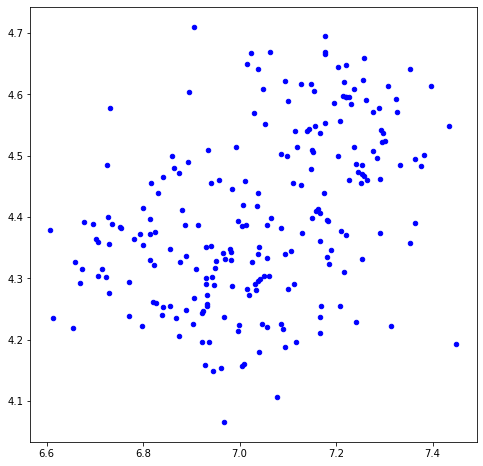

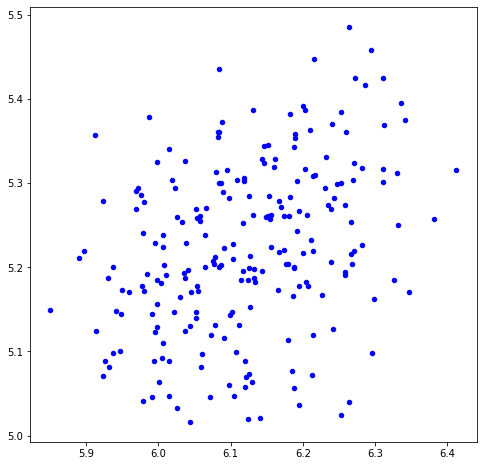

In [290]:
# piop2_rh_2d vs piop2_lh_2d 

emb_piop2_rh = umap.UMAP(random_state=30, n_neighbors=30,
                            min_dist=0.0, n_components=50).fit_transform(piop2_rh_2d)

fig = plt.figure(figsize=(4,4))
plt.scatter(emb_piop2_rh[:,0], emb_piop2_rh[:,1], s=20, c='Blue')
plt.show()



emb_piop2_lh = umap.UMAP(random_state=30, n_neighbors=30,
                            min_dist=0.0, n_components=50).fit_transform(piop2_lh_2d)

fig = plt.figure(figsize=(4,4))
plt.scatter(emb_piop2_lh[:,0], emb_piop2_lh[:,1], s=20, c='Blue')
plt.show()



In [291]:
### into a dataframe


### add rh
dimColList_rh = ['dimRH'+str(x) for x in range(len(emb_piop2_rh[0]))]; #print(dimColList)
temp = pd.DataFrame(data=emb_piop2_rh, columns=dimColList_rh)
# concat
df_piop2 = pd.concat([df, temp], axis=1)

### add lh
dimColList_lh = ['dimLH'+str(x) for x in range(len(emb_piop2_lh[0]))]; #print(dimColList)
temp = pd.DataFrame(data=emb_piop2_lh, columns=dimColList_lh)
# concat
df_piop2 = pd.concat([df_piop2, temp], axis=1)

### dropna
df_piop2_cor = df_piop2.dropna()
df_piop2_cor['handedness'].replace(['right','left', 'ambidextrous'],['right','left', 'left'],inplace=True)
df_piop2_cor.head()



/Users/pat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,...,dimLH40,dimLH41,dimLH42,dimLH43,dimLH44,dimLH45,dimLH46,dimLH47,dimLH48,dimLH49
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,...,5.350950,5.868692,3.897166,3.725882,5.298480,5.425756,5.905851,3.381167,5.185288,5.806569
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,...,5.045963,5.948693,4.357083,3.920241,5.249104,5.630343,5.393844,3.798972,5.131164,6.334433
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,...,5.004577,5.821193,4.160175,3.762518,5.485738,5.519133,5.966628,3.296843,5.203889,5.884828
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,...,5.013661,5.835203,4.168804,3.877455,5.306698,5.599836,5.731510,3.357692,4.880507,5.992732
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,...,4.744166,6.314634,4.433149,3.717842,5.332019,5.417495,5.534531,3.606691,4.813791,5.739068


In [294]:
### sex classification LH vs RH

#
scores_sex_lh = run_cross_validation(X=dimColList_lh, y='sex', data= df_piop2_cor,
                              model='svm', seed=42, preprocess_X='zscore',
                              scoring=['accuracy', 'balanced_accuracy'])

scores_sex_rh = run_cross_validation(X=dimColList_rh, y='sex', data= df_piop2_cor,
                              model='svm', seed=42, preprocess_X='zscore',
                              scoring=['accuracy', 'balanced_accuracy'])



print('LH: '+str(scores_sex_lh['test_accuracy'].mean()))
print('LH: '+str(scores_sex_lh['test_balanced_accuracy'].mean()))
print('')
print('RH: '+str(scores_sex_rh['test_accuracy'].mean()))
print('RH: '+str(scores_sex_rh['test_balanced_accuracy'].mean()))

LH: 0.5803232323232322
LH: 0.5625549935814513

RH: 0.5752525252525252
RH: 0.5708955781071486


---
### classify hemispheres: change number of dimensions
---

--PIOP2--

In [313]:
umap_params = {}
DFs = {}
svm_models_acc = {}
svm_models_predLH = {}
svm_models_predRH = {}
svm_results = {}

# list of sides called "side" was defined further above 


### for loop
for i in range(2, 401):
    name = "emb"+str(i)
    print("--- {name} ---".format(name=name))
# umap
    umap_params[name] = umap.UMAP(random_state=25, n_neighbors=30,min_dist=0.0,
                                  n_components=i).fit_transform(piop2_X)
    dim = ['dim'+str(x) for x in range(len(umap_params[name][0]))]
# DFs --> prepare for classifier
    DFs[name] = pd.DataFrame(data=umap_params[name], columns=dim)
    X = list(DFs[name].columns.map(str)) # get set of features as list
    DFs[name].insert(0, 'side', side, True) # include side information in DF
# svm
    # accuracy
    svm_models_acc[name] = run_cross_validation(X=X, y='side', data=DFs[name], model='svm', seed=42,
                              preprocess_X='zscore', scoring=['accuracy', 'balanced_accuracy'])
    svm_results[name] = [svm_models_acc[name]['test_accuracy'], 
                         svm_models_acc[name]['test_balanced_accuracy']]
    # precision_LH
    svm_models_predLH[name] = run_cross_validation(X=X, y='side', data=DFs[name], model='svm', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='left')
    svm_results[name].append(svm_models_predLH[name]['test_precision'])
    # precision_RH
    svm_models_predRH[name] = run_cross_validation(X=X, y='side', data=DFs[name], model='svm', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='right')
    svm_results[name].append(svm_models_predRH[name]['test_precision'])
# print results
    print(str(name)+" accuracy: "+str(svm_results[name][0].mean())
    print(str(name)+" balanced_acc: "+str(svm_results[name][1].mean()))
    print(str(name)+" LH_precision: "+str(svm_results[name][2].mean()))
    print(str(name)+" RH_precision: "+str(svm_results[name][3].mean()))
    print("")


--- emb2 ---
emb2 accuracy: 0     0.890110
1     0.868132
2     0.911111
3     0.866667
4     0.877778
5     0.890110
6     0.868132
7     0.911111
8     0.877778
9     0.855556
10    0.901099
11    0.879121
12    0.888889
13    0.855556
14    0.877778
15    0.846154
16    0.780220
17    0.922222
18    0.944444
19    0.911111
20    0.890110
21    0.879121
22    0.900000
23    0.888889
24    0.811111
Name: test_accuracy, dtype: float64
emb2 balanced_acc: 0     0.891156
1     0.860784
2     0.911925
3     0.865413
4     0.880010
5     0.888566
6     0.875610
7     0.915000
8     0.877500
9     0.854775
10    0.900641
11    0.878261
12    0.886690
13    0.850649
14    0.876482
15    0.843810
16    0.779554
17    0.916290
18    0.947964
19    0.910079
20    0.894558
21    0.882994
22    0.893665
23    0.889328
24    0.811759
Name: test_balanced_accuracy, dtype: float64
emb2 LH_precision: 0     0.914894
1     0.888889
2     0.933333
3     0.878049
4     0.928571
5     0.902439
6     0.95238

In [317]:
df2_results = pd.DataFrame.from_dict(svm_results, orient='index', columns=['accuracy',
                                                          'balanced_acc',
                                                          'LH_precision',
                                                          'RH_precision'])
#df2_results.head()
                                                          
svm_results['emb2'][0].mean()




0.8796923076923077

In [348]:
svm_resultsMean1 = {}

for k in svm_results1.keys():
    svm_resultsMean1[k]=[svm_results1[k][0].mean(), svm_results1[k][1].mean(),
                       svm_results1[k][2].mean(), svm_results1[k][3].mean()]

df1_results = pd.DataFrame.from_dict(svm_resultsMean1, orient='index', columns=['accuracy',
                                                          'balanced_acc',
                                                          'LH_precision',
                                                          'RH_precision'])
temp = [x for x in range(2, 401)]
df1_results['dim']=temp

df1_results.head()





,accuracy,balanced_acc,LH_precision,RH_precision,dim
emb2,0.879692,0.879339,0.908458,0.854476,2
emb3,0.856664,0.856783,0.908118,0.816304,3
emb4,0.843375,0.843980,0.890353,0.806798,4
emb5,0.832786,0.832758,0.872604,0.799998,5
emb6,0.837661,0.838608,0.878981,0.804311,6


<function matplotlib.pyplot.show(*args, **kw)>

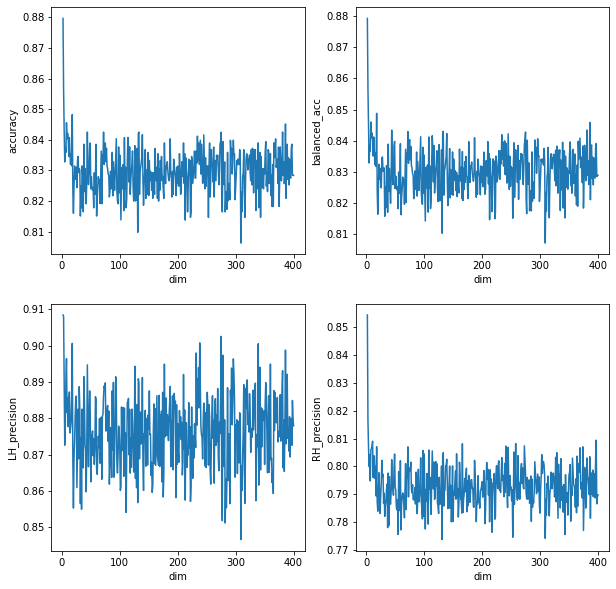

In [356]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=False, sharex=False)
sns.lineplot(data=df2_results, x='dim', y='accuracy', ax=ax[0,0])
sns.lineplot(data=df2_results, x='dim', y='balanced_acc', ax=ax[0,1])
sns.lineplot(data=df2_results, x='dim', y='LH_precision', ax=ax[1,0])
sns.lineplot(data=df2_results, x='dim', y='RH_precision',  ax=ax[1,1])

# only show maximum and minimum
    #    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.show

-- PIOP2 --

In [368]:
#side1 = ['right']*int(piop1_X.shape[0]/2) + ['left']*int(piop1_X.shape[0]/2); print(side1)

In [369]:
umap_params1 = {}
DFs1 = {}
svm_models_acc1 = {}
svm_models_predLH1 = {}
svm_models_predRH1 = {}
svm_results1 = {}
side1 = ['right']*int(piop1_X.shape[0]/2) + ['left']*int(piop1_X.shape[0]/2)

### for loop
for i in range(2, 401):
    name = "emb"+str(i)
    print("--- {name} ---".format(name=name))
# umap
    umap_params1[name] = umap.UMAP(random_state=25, n_neighbors=30,min_dist=0.0,
                                  n_components=i).fit_transform(piop1_X)
    dim = ['dim'+str(x) for x in range(len(umap_params[name][0]))]
# DFs --> prepare for classifier
    DFs1[name] = pd.DataFrame(data=umap_params1[name], columns=dim)
    X = list(DFs1[name].columns.map(str)) # get set of features as list
    DFs1[name].insert(0, 'side', side1, True) # include side information in DF
# svm
    # accuracy
    svm_models_acc1[name] = run_cross_validation(X=X, y='side', data=DFs1[name], model='svm', seed=42,
                              preprocess_X='zscore', scoring=['accuracy', 'balanced_accuracy'])
    svm_results1[name] = [svm_models_acc1[name]['test_accuracy'], 
                         svm_models_acc1[name]['test_balanced_accuracy']]
    # precision_LH
    svm_models_predLH1[name] = run_cross_validation(X=X, y='side', data=DFs1[name], model='svm', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='left')
    svm_results1[name].append(svm_models_predLH1[name]['test_precision'])
    # precision_RH
    svm_models_predRH1[name] = run_cross_validation(X=X, y='side', data=DFs1[name], model='svm', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='right')
    svm_results1[name].append(svm_models_predRH1[name]['test_precision'])
# print results
    print(str(name)+" accuracy: "+str(svm_results1[name][0].mean()))
    print(str(name)+" balanced_acc: "+str(svm_results1[name][1].mean()))
    print(str(name)+" LH_precision: "+str(svm_results1[name][2].mean()))
    print(str(name)+" RH_precision: "+str(svm_results1[name][3].mean()))
    print("")

--- emb2 ---
emb2 accuracy: 0.7800588078053997
emb2 balanced_acc: 0.7797413948255897
emb2 LH_precision: 0.8014958466817588
emb2 RH_precision: 0.7630528862795704

--- emb3 ---
emb3 accuracy: 0.8235712376369955
emb3 balanced_acc: 0.8240512942591062
emb3 LH_precision: 0.858007426175173
emb3 RH_precision: 0.7979632200053557

--- emb4 ---
emb4 accuracy: 0.7888318631381983
emb4 balanced_acc: 0.7881766608867253
emb4 LH_precision: 0.8233805660107956
emb4 RH_precision: 0.7654020210369634

--- emb5 ---
emb5 accuracy: 0.7795936915263297
emb5 balanced_acc: 0.7784069331158489
emb5 LH_precision: 0.8275034671822276
emb5 RH_precision: 0.7452329912041984

--- emb6 ---
emb6 accuracy: 0.780491847099706
emb6 balanced_acc: 0.7796565845683565
emb6 LH_precision: 0.8103884939185082
emb6 RH_precision: 0.7581919291045025

--- emb7 ---
emb7 accuracy: 0.7846778936113337
emb7 balanced_acc: 0.7835050132309941
emb7 LH_precision: 0.8249500080218886
emb7 RH_precision: 0.7552653615960575

--- emb8 ---
emb8 accuracy: 0.

In [370]:
### create dataframe for classification results from piop1

svm_resultsMean1 = {}

for k in svm_results1.keys():
    svm_resultsMean1[k]=[svm_results1[k][0].mean(), svm_results1[k][1].mean(),
                       svm_results1[k][2].mean(), svm_results1[k][3].mean()]

df1_results = pd.DataFrame.from_dict(svm_resultsMean1, orient='index', columns=['accuracy',
                                                          'balanced_acc',
                                                          'LH_precision',
                                                          'RH_precision'])
temp = [x for x in range(2, 401)]
df1_results['dim']=temp

df1_results.head()



,accuracy,balanced_acc,LH_precision,RH_precision,dim
emb2,0.780059,0.779741,0.801496,0.763053,2
emb3,0.823571,0.824051,0.858007,0.797963,3
emb4,0.788832,0.788177,0.823381,0.765402,4
emb5,0.779594,0.778407,0.827503,0.745233,5
emb6,0.780492,0.779657,0.810388,0.758192,6


<function matplotlib.pyplot.show(*args, **kw)>

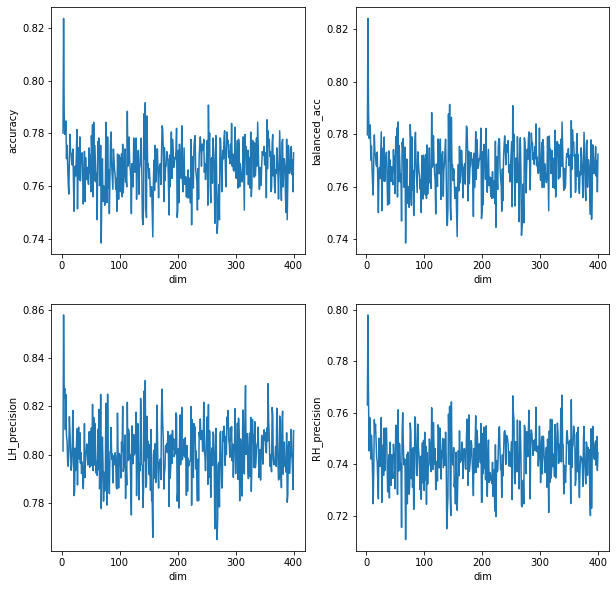

In [371]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=False, sharex=False)
sns.lineplot(data=df1_results, x='dim', y='accuracy', ax=ax[0,0])
sns.lineplot(data=df1_results, x='dim', y='balanced_acc', ax=ax[0,1])
sns.lineplot(data=df1_results, x='dim', y='LH_precision', ax=ax[1,0])
sns.lineplot(data=df1_results, x='dim', y='RH_precision',  ax=ax[1,1])

# only show maximum and minimum
    #    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.show

In [388]:
temp = ['piop2']*len(df2_results['dim'])
df2_results['dataset']=temp
df2_results

,accuracy,balanced_acc,LH_precision,RH_precision,dim,dataset
emb2,0.879692,0.879339,0.908458,0.854476,2,piop2
emb3,0.856664,0.856783,0.908118,0.816304,3,piop2
emb4,0.843375,0.843980,0.890353,0.806798,4,piop2
emb5,0.832786,0.832758,0.872604,0.799998,5,piop2
emb6,0.837661,0.838608,0.878981,0.804311,6,piop2
...,...,...,...,...,...,...
emb396,0.837245,0.837725,0.879935,0.802773,396,piop2
emb397,0.838574,0.839038,0.872586,0.809451,397,piop2
emb398,0.828405,0.828439,0.884914,0.786551,398,piop2
emb399,0.828425,0.828735,0.880200,0.789034,399,piop2


<function matplotlib.pyplot.show(*args, **kw)>

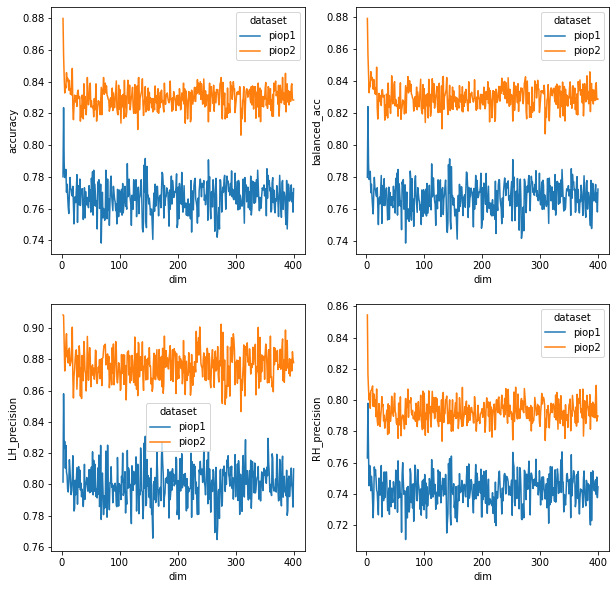

In [393]:
### both in one 
# prep piop1
temp = ['piop1']*len(df1_results['dim'])
df1_results['dataset']=temp
# prep piop2
temp = ['piop2']*len(df2_results['dim'])
df2_results['dataset']=temp
# concat
frames = [df1_results, df2_results]
results_both = pd.concat(frames)

### figure
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=False, sharex=False)
sns.lineplot(data=results_both, x='dim', y='accuracy', ax=ax[0,0], hue='dataset')
sns.lineplot(data=results_both, x='dim', y='balanced_acc', ax=ax[0,1], hue='dataset')
sns.lineplot(data=results_both, x='dim', y='LH_precision', ax=ax[1,0], hue='dataset')
sns.lineplot(data=results_both, x='dim', y='RH_precision',  ax=ax[1,1], hue='dataset')
# only show maximum and minimum
    #    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.show


##### --- test RF and compare with SVM ---

In [395]:
#

In [397]:
#### piop1


# we got DFs
rf_models_acc1 = {}
rf_models_predLH1 = {}
rf_models_predRH1 = {}
rf_results1 = {}

### for loop
for name in DFs1.keys():
    print("--- {name} ---".format(name=name))
# rf
    # accuracy
    rf_models_acc1[name] = run_cross_validation(X=X, y='side', data=DFs1[name], model='rf', seed=42,
                              preprocess_X='zscore', scoring=['accuracy', 'balanced_accuracy'])
    rf_results1[name] = [rf_models_acc1[name]['test_accuracy'], 
                         rf_models_acc1[name]['test_balanced_accuracy']]
    # precision_LH
    rf_models_predLH1[name] = run_cross_validation(X=X, y='side', data=DFs1[name], model='rf', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='left')
    rf_results1[name].append(svm_models_predLH1[name]['test_precision'])
    # precision_RH
    rf_models_predRH1[name] = run_cross_validation(X=X, y='side', data=DFs1[name], model='rf', seed=42,
                              preprocess_X='zscore', scoring='precision', pos_labels='right')
    rf_results1[name].append(svm_models_predRH1[name]['test_precision'])
# print results
    print(str(name)+" accuracy: "+str(rf_results1[name][0].mean()))
    print(str(name)+" balanced_acc: "+str(rf_results1[name][1].mean()))
    print(str(name)+" LH_precision: "+str(rf_results1[name][2].mean()))
    print(str(name)+" RH_precision: "+str(rf_results1[name][3].mean()))
    print("")

--- emb2 ---


ValueError: All elements must be matched. The following are missing: ['dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16', 'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24', 'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32', 'dim33', 'dim34', 'dim35', 'dim36', 'dim37', 'dim38', 'dim39', 'dim40', 'dim41', 'dim42', 'dim43', 'dim44', 'dim45', 'dim46', 'dim47', 'dim48', 'dim49', 'dim50', 'dim51', 'dim52', 'dim53', 'dim54', 'dim55', 'dim56', 'dim57', 'dim58', 'dim59', 'dim60', 'dim61', 'dim62', 'dim63', 'dim64', 'dim65', 'dim66', 'dim67', 'dim68', 'dim69', 'dim70', 'dim71', 'dim72', 'dim73', 'dim74', 'dim75', 'dim76', 'dim77', 'dim78', 'dim79', 'dim80', 'dim81', 'dim82', 'dim83', 'dim84', 'dim85', 'dim86', 'dim87', 'dim88', 'dim89', 'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98', 'dim99', 'dim100', 'dim101', 'dim102', 'dim103', 'dim104', 'dim105', 'dim106', 'dim107', 'dim108', 'dim109', 'dim110', 'dim111', 'dim112', 'dim113', 'dim114', 'dim115', 'dim116', 'dim117', 'dim118', 'dim119', 'dim120', 'dim121', 'dim122', 'dim123', 'dim124', 'dim125', 'dim126', 'dim127', 'dim128', 'dim129', 'dim130', 'dim131', 'dim132', 'dim133', 'dim134', 'dim135', 'dim136', 'dim137', 'dim138', 'dim139', 'dim140', 'dim141', 'dim142', 'dim143', 'dim144', 'dim145', 'dim146', 'dim147', 'dim148', 'dim149', 'dim150', 'dim151', 'dim152', 'dim153', 'dim154', 'dim155', 'dim156', 'dim157', 'dim158', 'dim159', 'dim160', 'dim161', 'dim162', 'dim163', 'dim164', 'dim165', 'dim166', 'dim167', 'dim168', 'dim169', 'dim170', 'dim171', 'dim172', 'dim173', 'dim174', 'dim175', 'dim176', 'dim177', 'dim178', 'dim179', 'dim180', 'dim181', 'dim182', 'dim183', 'dim184', 'dim185', 'dim186', 'dim187', 'dim188', 'dim189', 'dim190', 'dim191', 'dim192', 'dim193', 'dim194', 'dim195', 'dim196', 'dim197', 'dim198', 'dim199', 'dim200', 'dim201', 'dim202', 'dim203', 'dim204', 'dim205', 'dim206', 'dim207', 'dim208', 'dim209', 'dim210', 'dim211', 'dim212', 'dim213', 'dim214', 'dim215', 'dim216', 'dim217', 'dim218', 'dim219', 'dim220', 'dim221', 'dim222', 'dim223', 'dim224', 'dim225', 'dim226', 'dim227', 'dim228', 'dim229', 'dim230', 'dim231', 'dim232', 'dim233', 'dim234', 'dim235', 'dim236', 'dim237', 'dim238', 'dim239', 'dim240', 'dim241', 'dim242', 'dim243', 'dim244', 'dim245', 'dim246', 'dim247', 'dim248', 'dim249', 'dim250', 'dim251', 'dim252', 'dim253', 'dim254', 'dim255', 'dim256', 'dim257', 'dim258', 'dim259', 'dim260', 'dim261', 'dim262', 'dim263', 'dim264', 'dim265', 'dim266', 'dim267', 'dim268', 'dim269', 'dim270', 'dim271', 'dim272', 'dim273', 'dim274', 'dim275', 'dim276', 'dim277', 'dim278', 'dim279', 'dim280', 'dim281', 'dim282', 'dim283', 'dim284', 'dim285', 'dim286', 'dim287', 'dim288', 'dim289', 'dim290', 'dim291', 'dim292', 'dim293', 'dim294', 'dim295', 'dim296', 'dim297', 'dim298', 'dim299', 'dim300', 'dim301', 'dim302', 'dim303', 'dim304', 'dim305', 'dim306', 'dim307', 'dim308', 'dim309', 'dim310', 'dim311', 'dim312', 'dim313', 'dim314', 'dim315', 'dim316', 'dim317', 'dim318', 'dim319', 'dim320', 'dim321', 'dim322', 'dim323', 'dim324', 'dim325', 'dim326', 'dim327', 'dim328', 'dim329', 'dim330', 'dim331', 'dim332', 'dim333', 'dim334', 'dim335', 'dim336', 'dim337', 'dim338', 'dim339', 'dim340', 'dim341', 'dim342', 'dim343', 'dim344', 'dim345', 'dim346', 'dim347', 'dim348', 'dim349', 'dim350', 'dim351', 'dim352', 'dim353', 'dim354', 'dim355', 'dim356', 'dim357', 'dim358', 'dim359', 'dim360', 'dim361', 'dim362', 'dim363', 'dim364', 'dim365', 'dim366', 'dim367', 'dim368', 'dim369', 'dim370', 'dim371', 'dim372', 'dim373', 'dim374', 'dim375', 'dim376', 'dim377', 'dim378', 'dim379', 'dim380', 'dim381', 'dim382', 'dim383', 'dim384', 'dim385', 'dim386', 'dim387', 'dim388', 'dim389', 'dim390', 'dim391', 'dim392', 'dim393', 'dim394', 'dim395', 'dim396', 'dim397', 'dim398', 'dim399']

In [400]:
DFs1['emb2']

,side,dim0,dim1
0,right,6.766892,0.197096
1,right,9.455760,0.358012
2,right,8.750567,0.895607
3,right,7.039804,-0.538362
4,right,7.058894,0.514614
...,...,...,...
427,left,8.231985,-0.418244
428,left,10.102953,-0.749659
429,left,9.128367,0.243605
430,left,9.350339,-1.093657


---
# testing some stuff
---

In [3]:
import numpy as np
import umap
from matplotlib import pyplot as plt
import seaborn as sns


In [4]:
subj = np.arange(1, 227); print(subj)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226]


In [17]:
R = [str(x)+"R" for x in range(1,227)]
L = [str(x)+"L" for x in range(1,227)]
#x = right+left
#print(X)

# left
Lhalf = int(len(L)/2); print('Lhalf: '+str(Lhalf)); print("")
L_1sthalf = L[:Lhalf]; print('L_1sthalf: '+str(L_1sthalf)); print("")
R_2ndhalf = L[Lhalf:]; print('L_2ndhalf: '+str(L_2ndhalf)); print("")

# right
Rhalf = int(len(R)/2); print('Rhalf: '+str(Rhalf)); print("")
R_1sthalf = R[:Rhalf]; print('R_1sthalf: '+str(R_1sthalf)); print("")
R_2ndhalf = R[Rhalf:]; print('R_2ndhalf: '+str(R_2ndhalf)); print("")

train = np.concatenate((R_1sthalf, L_1sthalf), axis=0); print('train: '+str(train)); print("")
test = np.concatenate((R_2ndhalf, L_2ndhalf), axis=0); print('test: '+str(test)); print("")

Lhalf: 113

L_1sthalf: ['1L', '2L', '3L', '4L', '5L', '6L', '7L', '8L', '9L', '10L', '11L', '12L', '13L', '14L', '15L', '16L', '17L', '18L', '19L', '20L', '21L', '22L', '23L', '24L', '25L', '26L', '27L', '28L', '29L', '30L', '31L', '32L', '33L', '34L', '35L', '36L', '37L', '38L', '39L', '40L', '41L', '42L', '43L', '44L', '45L', '46L', '47L', '48L', '49L', '50L', '51L', '52L', '53L', '54L', '55L', '56L', '57L', '58L', '59L', '60L', '61L', '62L', '63L', '64L', '65L', '66L', '67L', '68L', '69L', '70L', '71L', '72L', '73L', '74L', '75L', '76L', '77L', '78L', '79L', '80L', '81L', '82L', '83L', '84L', '85L', '86L', '87L', '88L', '89L', '90L', '91L', '92L', '93L', '94L', '95L', '96L', '97L', '98L', '99L', '100L', '101L', '102L', '103L', '104L', '105L', '106L', '107L', '108L', '109L', '110L', '111L', '112L', '113L']

L_2ndhalf: ['114L', '115L', '116L', '117L', '118L', '119L', '120L', '121L', '122L', '123L', '124L', '125L', '126L', '127L', '128L', '129L', '130L', '131L', '132L', '133L', '134L',

In [18]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test